In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def showImg(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.show()

def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')
    print('%s saved' % 'out.ply')
        
def convert_imgs_to_grayscale(img_left_color, img_right_color):
    img_left_bw = cv2.blur(cv2.cvtColor(img_left_color, cv2.COLOR_RGB2GRAY), (5, 5))
    img_right_bw = cv2.blur(cv2.cvtColor(img_right_color, cv2.COLOR_RGB2GRAY), (5, 5))
    return img_left_bw, img_right_bw

def perform_stereo_matching(img_left_bw, img_right_bw):
    stereo = cv2.StereoBM_create(numDisparities=96, blockSize=11)
    disparity = stereo.compute(img_left_bw, img_right_bw)
    return disparity

def reading_calibration():
    matrix_type_1 = 'P2'
    matrix_type_2 = 'P3'
    calib_file = "./notebooks/3d_reconstruction/data_road/training/calib/um_000000.txt"
    with open(calib_file, 'r') as f:
        fin = f.readlines()
        for line in fin:
            if line[:2] == matrix_type_1:
                calib_matrix_1 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3, -1)
            elif line[:2] == matrix_type_2:
                calib_matrix_2 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3, -1)
    return calib_matrix_1, calib_matrix_2

def calculate_depth_to_disparity(img_left_color, calib_matrix_1, calib_matrix_2, disparity):
    cam1 = calib_matrix_1[:, :3]  # left image - P2
    cam2 = calib_matrix_2[:, :3]  # right image - P3
    Tmat = np.array([0.54, 0., 0.])
    rev_proj_matrix = np.zeros((4, 4))
    
    cv2.stereoRectify(cameraMatrix1=cam1, cameraMatrix2=cam2,
                      distCoeffs1=0, distCoeffs2=0,
                      imageSize=img_left_color.shape[:2],
                      R=np.identity(3), T=Tmat,
                      R1=None, R2=None,
                      P1=None, P2=None, Q=rev_proj_matrix)
    
    points = cv2.reprojectImageTo3D(disparity, rev_proj_matrix)
    return points, cam2

def reflect_on_x_axis(points):
    reflect_matrix = np.identity(3)
    reflect_matrix[0] *= -1
    points = np.matmul(points, reflect_matrix)
    return points, reflect_matrix

def filter_by_min_disparity(disparity, points, colors):
    mask = disparity > disparity.min()
    out_points = points[mask]
    out_colors = colors[mask]
    return mask, out_points, out_colors

def filter_by_dimension(out_points, out_colors):
    idx = np.fabs(out_points[:, 0]) < 4.5
    out_points = out_points[idx]
    out_colors = out_colors.reshape(-1, 3)
    out_colors = out_colors[idx]
    return idx, out_points, out_colors

def display_3d_reconstruction(img_left_color, img_right_color, mask, idx, projected_img):
    blank_img = np.zeros(img_left_color.shape, 'uint8')
    img_colors = img_right_color[mask][idx].reshape(-1, 3)

    for i, pt in enumerate(projected_img):
        pt_x = int(pt[0])
        pt_y = int(pt[1])
        if pt_x > 0 and pt_y > 0:
            col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
            cv2.circle(blank_img, (pt_x, pt_y), 1, col)
    showImg(blank_img)

def reconstruction3d(img_left_color, img_right_color):
    # Convert images to grayscale
    img_left_bw, img_right_bw = convert_imgs_to_grayscale(img_left_color, img_right_color)
    
    # Perform stereo matching
    disparity = perform_stereo_matching(img_left_bw, img_right_bw)
    
    plt.imshow(disparity, 'CMRmap_r')
    plt.show()

    # Reading calibration
    calib_matrix_1, calib_matrix_2 = reading_calibration()

    # Calculate depth-to-disparity
    points, cam2 = calculate_depth_to_disparity(img_left_color, calib_matrix_1, calib_matrix_2, disparity)
    
    # Reflect on the x-axis
    points, reflect_matrix = reflect_on_x_axis(points)

    # Extract colors from image
    colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)

    # Filter by min disparity
    mask, out_points, out_colors = filter_by_min_disparity(disparity, points, colors)

    # Filter by dimension
    idx, out_points, out_colors = filter_by_dimension(out_points, out_colors)

    # Save the 3D reconstruction as a PLY file
    write_ply('out.ply', out_points, out_colors)

    # Reflect points for visualization
    reflected_pts = np.matmul(out_points, reflect_matrix)

    # Project points onto the right image
    projected_img, _ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]),
                                         cam2[:3, :3], np.array([0., 0., 0., 0.]))
    projected_img = projected_img.reshape(-1, 2)

    # Display the 3D reconstruction on the right image
    display_3d_reconstruction(img_left_color, img_right_color, mask, idx, projected_img)

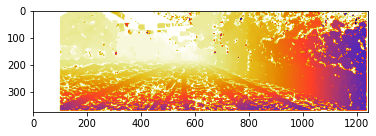

C:\Users\jonas\AppData\Local\Temp\ipykernel_13068\875147882.py:67: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflect_matrix)


out.ply saved


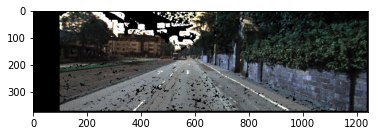

In [4]:
img_left_color = cv2.imread("./notebooks/3d_reconstruction/data_road/training/image_2/um_000001.png")
img_right_color = cv2.imread("./notebooks/3d_reconstruction/data_road/training_right/image_3/um_000001.png")
reconstruction3d(img_left_color, img_right_color)